<a href="https://colab.research.google.com/github/saspav/python_for_pro/blob/main/%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='green' size='6'>**Практическая работа 3**</font>  
<font color='#11a642' size='5'>**Тема: Машинное обучение**</font>  
<font size='5'>**Задание:**</font>  


**Ваша задача** — предсказать, останется ли клиент с аккаунтом или закроет его (например, уйдёт).

Требования к оформлению:
- Работа должна быть оформлена в jupyter notebook (файл *.ipynb)
- Работа должна содержать комментарии и выводы. Объясняйте почему вы выбрали именно этот способ обработки данных


Всем удачи!


# <font color='#11a642' size='6'> **Импорт и установка библиотек**

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap

from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
from optuna.integration import CatBoostPruningCallback
from catboost import CatBoostClassifier, Pool


import warnings
warnings.filterwarnings("ignore")

# Настройки отображения данных в Pandas
pd.set_option('display.max_columns', 50)  # Отображать до 50 столбцов
pd.set_option('display.precision', 5)  # Отображение ДФ с 5-ю знаками после запятой

In [ ]:
# Зафиксируем сиды

SEED = 127
np.random.seed(SEED)
random.seed(SEED)

# <font color='#11a642' size='6'> Функции, собранные из разных ДЗ 🧠

In [ ]:
def find_optimal_threshold(y_true, y_proba):
    # Функция для подбора оптимального порога
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    # Вычисляем F1-score для каждого порога
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    # Находим порог с максимальным F1
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold


def get_classification_metrics(y_true, y_pred, y_proba=None):
    """
    Расчёт метрик для бинарной классификации.
    :param y_true: истинные метки (0 или 1)
    :param y_pred: предсказанные метки (0 или 1)
    :param y_proba: вероятности положительного класса (по желанию)
    :return: словарь с метриками
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
    }

    if y_proba is not None:
        # y_proba должен быть вероятностями положительного класса
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba)

    return metrics


def train_valid_model(model_class, model_num, model_params, df_train, df_valid,
                      model_cols, target_col):
    """
    Процедура обучения и валидации модели
    :param model_class: Модель, которую используем для обучения
    :param model_num: Порядковый номер модели
    :param model_params: Параметры модели
    :param df_train: обучающий ДФ
    :param df_valid: валидационный ДФ
    :param model_cols: список признаков
    :param target_col: целевая переменная
    :return: обученная модель, ДФ с метриками
    """
    X_train, y_train = df_train[model_cols], df_train[target_col]
    X_valid, y_valid = df_valid[model_cols], df_valid[target_col]

    model = model_class(**model_params, random_state=SEED)

    model.fit(X_train, y_train)

    # Получение вероятностей
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_valid_proba = model.predict_proba(X_valid)[:, 1]

    # Подбираем порог на валидационной выборке
    optimal_threshold = find_optimal_threshold(y_valid, y_valid_proba)
    print(f"Оптимальный порог: {optimal_threshold:.4f}")
    # Применяем порог к обеим выборкам
    y_train_pred = (y_train_proba >= optimal_threshold).astype(int)
    y_valid_pred = (y_valid_proba >= optimal_threshold).astype(int)

    metrics_train = get_classification_metrics(y_train, y_train_pred, y_train_proba)
    metrics_valid = get_classification_metrics(y_valid, y_valid_pred, y_valid_proba)

    metric_t = f'Train{model_num}'
    metric_v = f'Valid{model_num}'

    # Создаем DataFrame
    metrics = pd.DataFrame({'Metric': list(metrics_train.keys()),
                            metric_t: list(metrics_train.values()),
                            metric_v: list(metrics_valid.values())})

    # Добавляем разницу между train и valid (в %)
    metrics[f'Diff{model_num},%'] = ((metrics[metric_v] - metrics[metric_t])
                                     / metrics[metric_t] * 100).round(2)
    return model, metrics


def find_best_model(metrics_df):
    """
    Процедура поиска лучшей модели по метрикам
    :param metrics_df: ДФ с метриками
    :return: None
    """
    models = []
    for idx, row in metrics_df.iterrows():
        metric_name = row['Metric']

        # Отбираем только численные значения из колонок Valid*
        valid_cols = [col for col in metrics_df.columns if col.startswith('Valid')]
        valid_values = row[valid_cols]

        best_col = valid_values.idxmax()
        best_val = valid_values.max()

        models.append(best_col)

        print(f"Метрика: {metric_name:<10} --> лучшая модель: {best_col} ({best_val:.4f})")

    result = Counter(models).most_common()[0]
    print('\nЛучшая модель: {} на {} метриках из {}'.format(*result, len(models)))


def plot_catboost_feature_importance(model, feature_names, name_model='CatBoost', top_n=20):
    """
    Визуализация важности признаков CatBoost-модели.

    :param model: Обученная CatBoost модель (CatBoostClassifier или Regressor)
    :param feature_names: Список признаков (в том же порядке, что использовались для обучения)
    :param top_n: Сколько самых важных признаков отобразить
    """
    # Получаем важности
    importances = model.get_feature_importance()

    # Создаём DataFrame
    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).reset_index(drop=True)

    # Отрисовка
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(top_n), palette='viridis')
    plt.title(f'{name_model} — Топ {top_n} признаков по важности')
    plt.xlabel('Важность')
    plt.ylabel('Признак')
    plt.tight_layout()
    plt.show()

    return feat_imp_df  # возвращаем на всякий случай

# <font color='#11a642' size='6'> **Загрузка данных**

In [ ]:
try:
    url = 'https://drive.google.com/uc?id=1wvqGslWLauKyZxLY-d3RQCTyHCb5wJCO'
    df = pd.read_csv(url)
except:
    df = pd.read_csv('train.csv')

In [ ]:
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [ ]:
# Колонка "id" не несет смысла - это индекс
df.set_index("id", inplace=True)

In [ ]:
# 2. Разделение признаков и целевой переменной
X = df.drop('Exited', axis=1)
y = df[['Exited']]

## <font color='#11a642' size='5'> Напишите ответы на следующие вопросы: </font>


1.   К какому типу переменных относится целевой признак?
2.   Какую задачу машинного обучения вам предстоит решить, регрессия или классификация?

In [ ]:
y.value_counts()

Exited
0         130113
1          34921
Name: count, dtype: int64

# ваш ответ
1. В целевом признаке только 2 целочисленных значения.
2. Таким образом мы будем решать задачу бинарной классификации.

# <font color='#11a642' size='6'> **Разведочный анализ данных(можно переиспользовать из ДЗ 9)**

## <font color='#11a642' size='5'> Оцените размер вашего датасета  </font>



1.   Сколько ГБ ваш датасет
2.   Сколько строк и столбцов



In [ ]:
# Сколько ГБ ваш датасет
df.memory_usage(deep=True).sum() / 1024 ** 3

0.04248335398733616

In [ ]:
# Сколько строк и столбцов
df.shape

(165034, 13)

In [ ]:
# Дубликатов нет

df.duplicated().sum()

0

## <font color='#11a642' size='5'> Анализ числовых (непрерывных) признаков


- для каждого признака посчитайте минимум, максимум, среднее, медиану

In [ ]:
# Выбираем числовые колонки
num_cols = X.select_dtypes(include=['number']).columns.tolist()
# Считаем требуемые статистики
X[num_cols].agg(['min', 'max', 'mean', 'median']).T

,min,max,mean,median
CustomerId,1.55657e+07,1.58157e+07,1.56920e+07,15690169.0
CreditScore,3.50000e+02,8.50000e+02,6.56454e+02,659.0
Age,1.80000e+01,9.20000e+01,3.81259e+01,37.0
Tenure,0.00000e+00,1.00000e+01,5.02035e+00,5.0
Balance,0.00000e+00,2.50898e+05,5.54781e+04,0.0
NumOfProducts,1.00000e+00,4.00000e+00,1.55446e+00,2.0
HasCrCard,0.00000e+00,1.00000e+00,7.53954e-01,1.0
IsActiveMember,0.00000e+00,1.00000e+00,4.97770e-01,0.0
EstimatedSalary,1.15800e+01,1.99992e+05,1.12575e+05,117948.0


In [ ]:
# Посмотрим на распределение у идентификаторам пользователей

df.CustomerId.value_counts()

CustomerId
15682355    121
15570194     99
15585835     98
15595588     91
15648067     90
           ... 
15635203      1
15806982      1
15691104      1
15624936      1
15815050      1
Name: count, Length: 23221, dtype: int64

У некоторых пользователей под сотню аккаунтов.

Колонка "CustomerId" в данном датасете не несет смысловой нагрузки - это идентификатор пользователя, уберем его из обучения. В прошлой практической работе я добавлял новый признак 'count_id' - количество аккаунтов у пользователя, но метрики F1 и ROC_AUC ухудшились, я отказался от этого признака. Ниже код для добавления этого признака (После разделения выборки на тренировочную и валидационную).

In [ ]:
num_cols.remove('CustomerId')
num_cols

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

## <font color='#11a642' size='5'> Анализ категориальных признаков


- для каждого признака посчитайте моду, количество уникальных значений

In [ ]:
# Выбираем категориальные колонки (включая строки и категории)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
X[cat_cols].agg([lambda z: z.mode().tolist()[0], 'nunique']).T.rename(columns={'<lambda>': 'mode'})

,mode,nunique
Surname,Hsia,2797
Geography,France,3
Gender,Male,2


In [ ]:
# Колонка "Surname" не несет смысловой нагрузки, т.к. это имя
# с большим количеством уникальных значений уберем её из обучения

cat_cols.remove('Surname')
cat_cols

['Geography', 'Gender']

## <font color='#11a642' size='5'> Анализ целевого признака


- какая доля 1?

In [ ]:
y.value_counts(normalize=True)[1] * 100

21.159882206090867

# <font color='#11a642' size='6'> **Разделите данные на трейн и тест**

- нужна ли стратификация?

In [ ]:
# Т.к. у нас наблюдается дисбаланс классов: класс с меткой "1" всего 21%
# Будем делить со стратификацией

train, valid, X_train, X_valid, y_train, y_valid = train_test_split(df, X, y,
                                                                    test_size=0.2,
                                                                    stratify=y,
                                                                    random_state=SEED)

# <font color='#11a642' size='6'> **Подготовка данных к обучению**

## Поиск и анализ выбросов

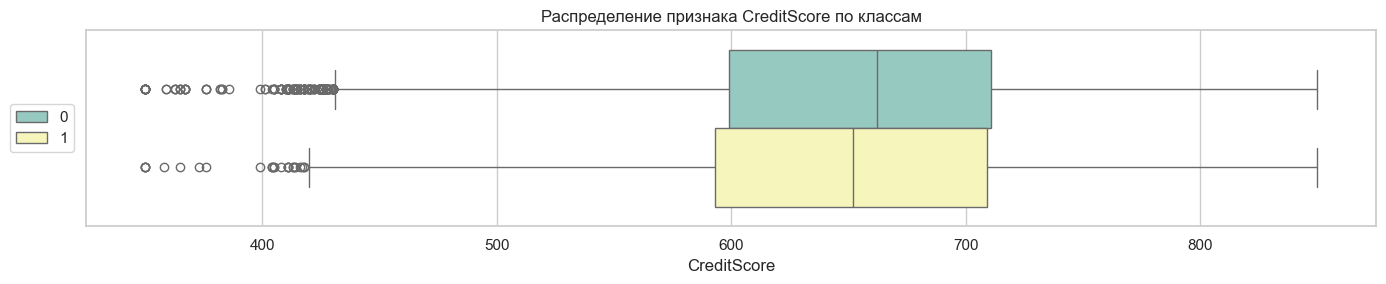

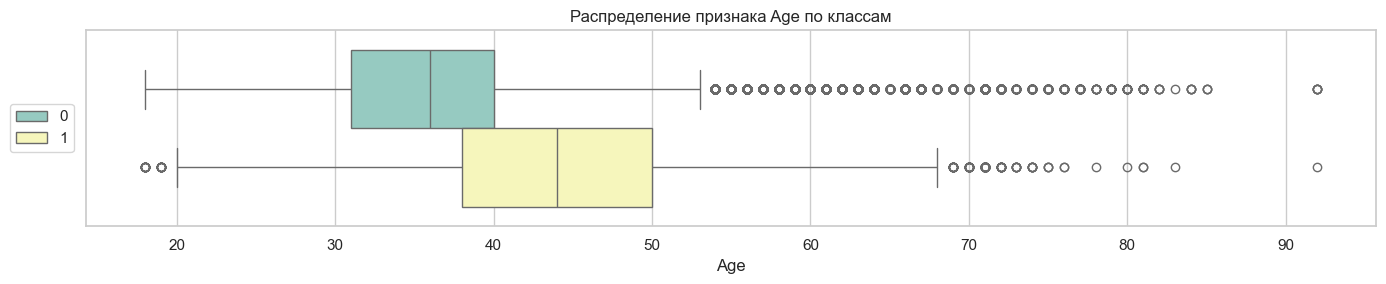

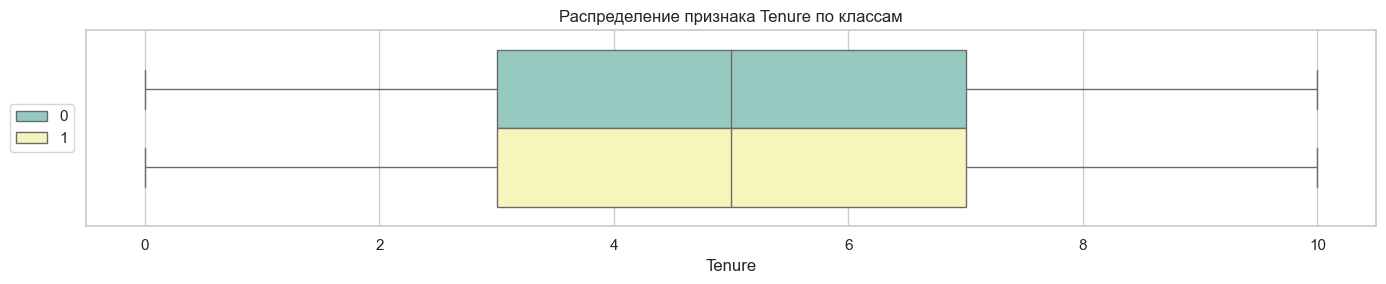

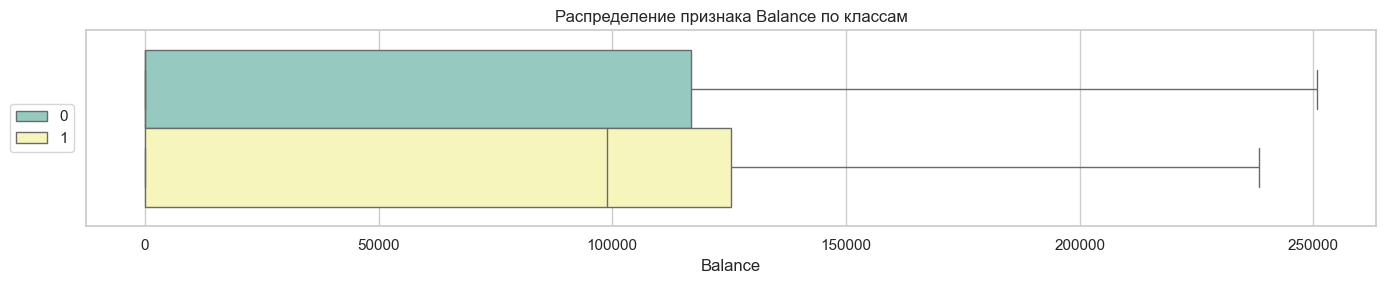

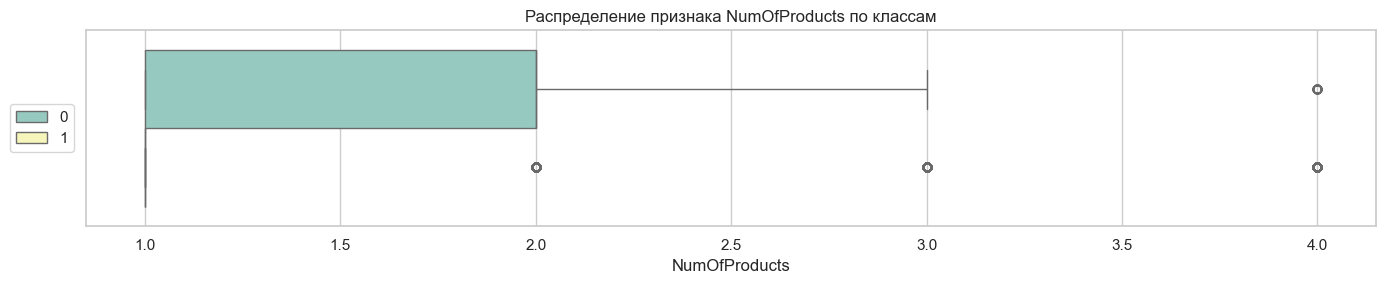

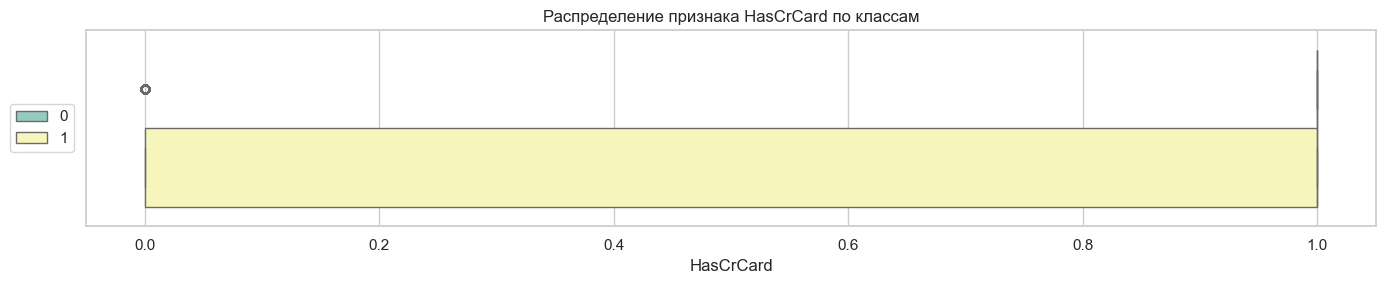

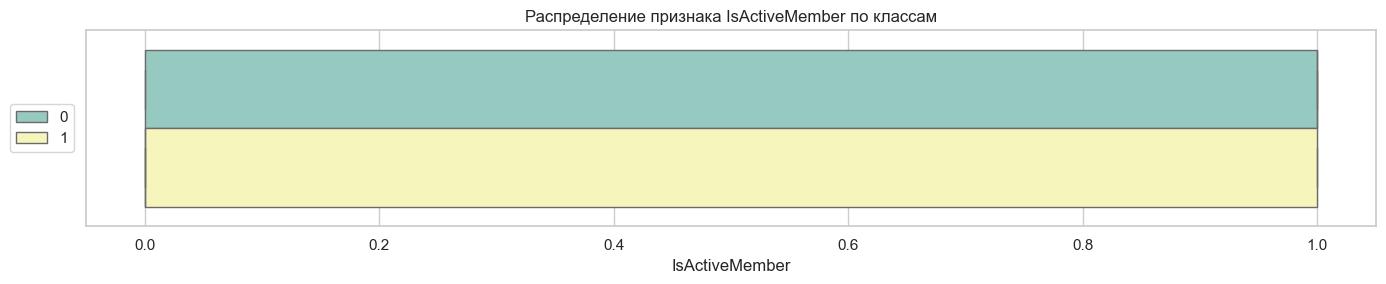

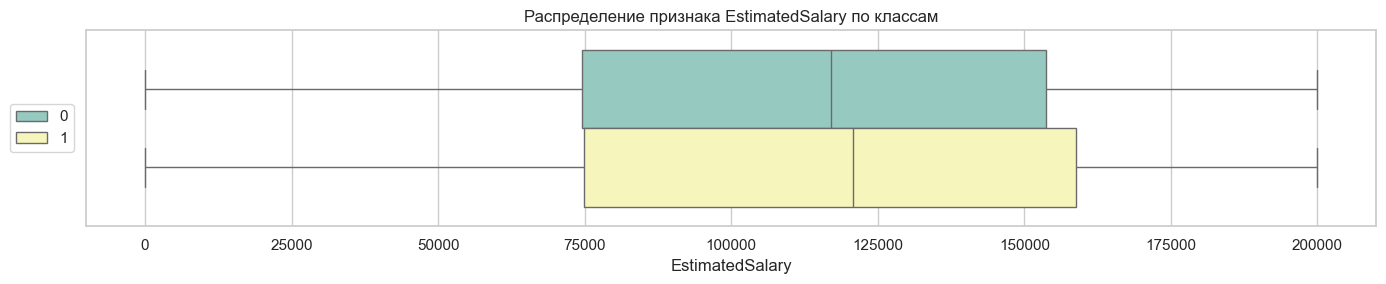

In [ ]:
sns.set(style='whitegrid')

for col in num_cols:
    plt.figure(figsize=(14, 3))
    sns.boxplot(data=train, x=col, hue='Exited', palette='Set3', legend=True)
    plt.title(f'Распределение признака {col} по классам')
    # Перемещаем легенду в левую часть и центрируем по высоте
    plt.legend(bbox_to_anchor=(-0.01, 0.5), loc='center right', borderaxespad=0)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

### Как **распределены числовые признаки в зависимости от целевой переменной (`Exited`)**:

---

## 📦 **1. `CreditScore`**

* **Распределение почти одинаковое** для классов `0` и `1`.
* **Медиана и межквартильный размах (IQR)** совпадают.
* ➤ **Вывод**: `CreditScore` **не сильно различает** клиентов, ушедших и оставшихся. Хотя по корреляции была небольшая связь, она **не линейная и не визуально заметная**.

---

## 👵 **2. `Age`**

* У ушедших клиентов (`1`) **медиана больше**, чем у оставшихся (`0`).
* Есть **больше выбросов** в сторону возрастов 60+ у класса `1`.
* ➤ **Вывод**: Чем **старше клиент, тем выше вероятность ухода**. Это хороший предиктор, особенно в сочетании с другими признаками.

---

## ⏳ **3. `Tenure`**

* Распределения очень **похожи** между классами.
* Медианы совпадают, IQR — тоже.
* ➤ **Вывод**: `Tenure` **не имеет сильного различия** по классам. Хотя по корреляции есть слабый отрицательный тренд, визуально он **не подтверждается**.

---

## 💰 **4. `Balance`**

* Распределения схожи, но:

  * У ушедших клиентов большее количество с **нулевым балансом**.
  * **Медианы и IQR примерно одинаковы**.
* ➤ **Вывод**: Признак слабый по отдельности, но **нулевой баланс** может быть важной фичей (бинарный признак `is_zero_balance`).

---

## 🧾 **5. `NumOfProducts`**

* У **класса 1 чаще встречается 2 продукта** (медиана выше).
* Небольшое количество клиентов с 3–4 продуктами ушли.
* ➤ **Вывод**: Количество продуктов важно, особенно если `> 2` — может означать недовольство или сложность обслуживания.

---

## 💳 **6. `HasCrCard`**

* Распределения **полностью совпадают**.
* ➤ **Вывод**: Наличие кредитной карты **не влияет** на уход. Можно потенциально **удалить признак**.

---

## 🔁 **7. `IsActiveMember`**

* У **оставшихся клиентов больше активных**.
* У ушедших — наоборот, больше неактивных.
* ➤ **Вывод**: Признак важен — **неактивные клиенты более склонны уходить**.

---

## 💼 **8. `EstimatedSalary`**

* Распределения **почти идентичны**, медианы и IQR совпадают.
* ➤ **Вывод**: Зарплата **не влияет** напрямую на уход. По корреляции она отрицательная, но **визуально не подтверждается**.

---

## 🔍 Общие выводы:

| Признак           | Визуальная важность | Комментарий                                 |
| ----------------- | ------------------- | ------------------------------------------- |
| `Age`             | ✅ высокая           | Старшие клиенты уходят чаще                 |
| `IsActiveMember`  | ✅ высокая           | Неактивные — склонны уходить                |
| `NumOfProducts`   | 🟡 средняя          | 2+ продукта — более рискованные             |
| `Tenure`          | 🔻 слабая           | Почти не различается                        |
| `CreditScore`     | 🔻 слабая           | Почти одинаково                             |
| `EstimatedSalary` | 🔻 очень слабая     | Визуально бесполезен                        |
| `HasCrCard`       | ❌ не влияет         | Одинаковое распределение                    |
| `Balance`         | 🟡 условная         | Возможно полезен бинарный `is_zero_balance` |

---

### 💡 Рекомендации:

1. **Добавить признаки для опытов с лучшей моделью**:

   * `is_zero_balance = (Balance == 0)`
   * `age_group = pd.cut(Age, bins=[0, 30, 45, 60, 100], labels=[0, 1, 2, 3])`
   * `many_products = (NumOfProducts > 2)`

2. **Удалить** слабые признаки (`HasCrCard`, `EstimatedSalary`) — если модель с регуляризацией.

3. **Покрутить признаки `Age`, `IsActiveMember`, `NumOfProducts`** — они визуально и статистически информативны.

In [ ]:
# Поиск выбросов с помощью IQR, но возьмет 2 IQR как более щадящую границу

Q1 = X_train[num_cols].quantile(0.25)
Q3 = X_train[num_cols].quantile(0.75)
IQR = Q3 - Q1

# Создаём DataFrame с флагами выбросов (True/False)
outlier_flags_train = (X_train[num_cols] < (Q1 - 2 * IQR)) | (X_train[num_cols] > (Q3 + 2 * IQR))

# Пример: вывести % выбросов по колонкам
outlier_percent = outlier_flags_train.mean().sort_values(ascending=False)
print("Процент выбросов по признакам:")
outlier_percent

Процент выбросов по признакам:


HasCrCard          0.24640
Age                0.01670
CreditScore        0.00023
Tenure             0.00000
Balance            0.00000
NumOfProducts      0.00000
IsActiveMember     0.00000
EstimatedSalary    0.00000
dtype: float64

In [ ]:
# HasCrCard - это бинарный признак в нем не может быть выбросов,
# удалим выбросы из признаков Age и CreditScore и сохраним в ДФ

# Целевая переменная
target = 'Exited'

train_out = train[~outlier_flags_train[['Age', 'CreditScore']].any(axis=1)]

X_train = train_out.drop(target, axis=1)
y_train = train_out[target]

X_train.shape

(129791, 12)

## Анализ и обработка пропусков

In [ ]:
X_train.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [ ]:
# На всем датасете

df.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

#### Нам повезло: датасет не имеет пропусков!

# <font color='#11a642' size='6'> **Построение моделей с помощью pipeline + подбор гиперпараметров**

In [ ]:
# Категориальный пайплайн
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

# Числовой пайплайн
num_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Объединяем в ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_pipeline, cat_cols),
    ('num', num_pipeline, num_cols)
])

In [ ]:
# Пайплайн для поиска метода масштабирования
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=SEED))
])
param_pipe = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
}
grid = GridSearchCV(
    pipe,
    param_grid=param_pipe,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid.fit(X_train, y_train)
df_cv_results = pd.DataFrame(grid.cv_results_)
df_cv_results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num__scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.11182,0.00481,0.01632,0.00057,StandardScaler(),{'preprocessor__num__scaler': StandardScaler()},0.53176,0.51728,0.52408,0.52676,0.51472,0.52292,0.00622,1
2,0.09728,0.00417,0.01491,0.00065,RobustScaler(),{'preprocessor__num__scaler': RobustScaler()},0.53176,0.51728,0.52414,0.52659,0.51472,0.52290,0.00620,2
1,0.14755,0.02224,0.01537,0.00082,MinMaxScaler(),{'preprocessor__num__scaler': MinMaxScaler()},0.53171,0.51649,0.52468,0.52645,0.51375,0.52262,0.00660,3


In [ ]:
best_scaler = grid.best_params_['preprocessor__num__scaler']
print(f"Лучший масштабатор: {best_scaler}")

Лучший масштабатор: StandardScaler()


In [ ]:
# Применяем трансформации
X_train_processed = preprocessor.fit_transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)

# Получаем имена признаков
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)
all_feature_names = num_cols + list(cat_feature_names)

# Преобразуем в DataFrame
train_df = pd.DataFrame(X_train_processed, columns=all_feature_names, index=X_train.index)
valid_df = pd.DataFrame(X_valid_processed, columns=all_feature_names, index=X_valid.index)
# Добавим в ДФ целевую переменную, для использования в функции обучения
train_df[target] = y_train
valid_df[target] = y_valid

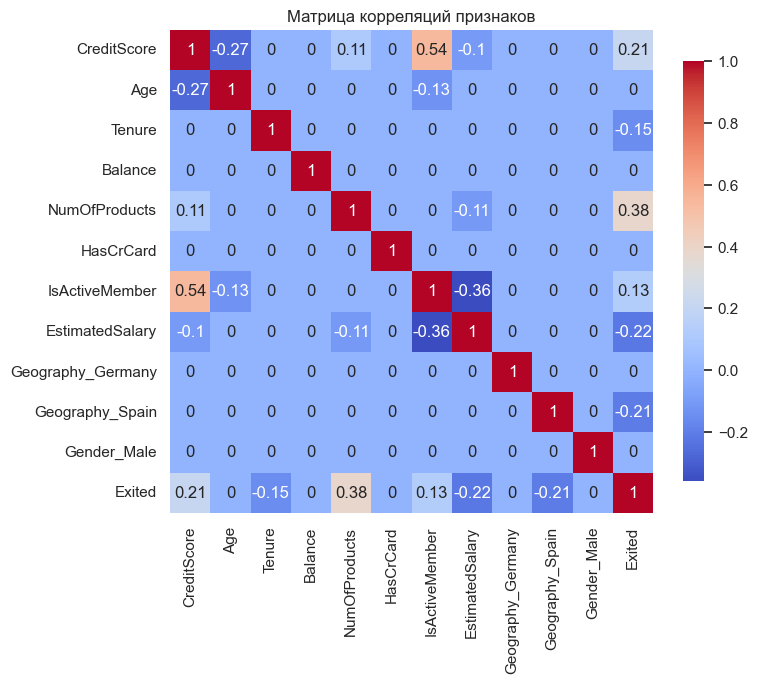

In [ ]:
# Матрица корреляций
corr_matrix = np.round(train_df.corr(),2)
# Зунулим значения не большой корреляции
corr_matrix[np.abs(corr_matrix) < 0.1] = 0

plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Матрица корреляций признаков")
plt.tight_layout()
plt.show()

## 🎯 **1. Корреляция с целевой переменной `Exited`**

| Признак                                                                                    | Корреляция с `Exited` | Интерпретация                                                                                                                                       |
| ------------------------------------------------------------------------------------------ | --------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------- |
| `NumOfProducts`                                                                            | **+0.38**             | 🔼 Чем **больше продуктов**, тем выше шанс ухода — возможно, клиенты с множеством продуктов более требовательны или находятся в группе риска ухода. |
| `CreditScore`                                                                              | **+0.21**             | 🔼 Люди с более **высоким скором** склонны уходить — неожиданно, но может говорить о том, что у них больше альтернатив.                             |
| `IsActiveMember`                                                                           | **+0.13**             | 🔼 Активные клиенты **уходят чаще** — может указывать на агрессивные действия конкурентов.                                                          |
| `Tenure`                                                                                   | **–0.15**             | 🔽 Чем **дольше клиент с банком**, тем **меньше шанс ухода** — логично, высокая привязка.                                                           |
| `EstimatedSalary`                                                                          | **–0.22**             | 🔽 Люди с **высокой зарплатой уходят реже** — вероятно, они довольны условиями.                                                                     |
| `Geography_Spain`                                                                          | **–0.21**             | 🔽 Клиенты из **Испании уходят реже**, чем из других стран.                                                                                         |
| `Balance`, `Age`, `HasCrCard`, `Gender_Male`, `Geography_Germany` — почти не коррелируют ( | corr                  | < 0.05), следовательно, **линейной связи почти нет**.                                                                                               |

👉 **Вывод:** наибольшую линейную связь с `Exited` имеют:

* **+ `NumOfProducts`, `CreditScore`, `IsActiveMember`**,
* **– `EstimatedSalary`, `Tenure`, `Geography_Spain`**

---

## 🔗 **2. Взаимные корреляции между признаками**

| Пара                                             | Коэффициент | Комментарий                                                                                                                     |
| ------------------------------------------------ | ----------- | ------------------------------------------------------------------------------------------------------------------------------- |
| `IsActiveMember` & `EstimatedSalary`             | –0.36       | 🔽 Активные клиенты часто имеют **меньшую зарплату** (возможно, активность измеряется не транзакциями, а визитами/обращениями). |
| `CreditScore` & `IsActiveMember`                 | +0.54       | 🔼 Более кредитоспособные люди **активнее**.                                                                                    |
| `EstimatedSalary` & `NumOfProducts`              | –0.11       | Незначительная обратная связь — **слабая**.                                                                                     |
| Остальные корреляции — слабые (в пределах ±0.1). |             |                                                                                                                                 |

👉 **Вывод:** признаки с высокой взаимной корреляцией:

* `IsActiveMember` и `CreditScore` — могут частично дублировать информацию.
* Однако **мультиколлинеарность** в целом слабая, что хорошо для большинства моделей.

---

## 🧠 **Практические выводы:**

1. **`NumOfProducts` — сильный индикатор** ухода, его стоит внимательно анализировать.
2. **`EstimatedSalary` и `Tenure` — "удерживающие" факторы** (чем выше, тем меньше вероятность ухода).
3. **Региональные различия (Spain)** имеют значение, а значит — **`Geography` стоит оставить**.
4. Признаки типа **`Balance`, `Gender_Male`, `HasCrCard`** почти не влияют на целевую переменную линейно, но это **не значит**, что они бесполезны — возможно, их влияние **нелинейное**.
5. Корреляция `CreditScore` с `IsActiveMember` может вызвать **слабую мультиколлинеарность**, но в пределах нормы.

## <font color='#11a642' size='5'> Построение логистической регрессии

In [ ]:
# Обучение логистической регрессии

params = {}
lr1, metrics_df = train_valid_model(LogisticRegression, 1, params,
                                    train_df, valid_df, all_feature_names, target)
metrics_df

Оптимальный порог: 0.2861


,Metric,Train1,Valid1,"Diff1,%"
0,accuracy,0.80835,0.79674,-1.44
1,precision,0.53721,0.51544,-4.05
2,recall,0.65486,0.65736,0.38
3,f1,0.59023,0.57781,-2.10
4,roc_auc,0.82618,0.81486,-1.37


## <font color='#11a642' size='5'> Построение логистической регрессии с регуляризацией
> можно использовать [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression), настроив гиперпараметры penalty и C

### Подбор гиперпараметров

In [ ]:
def objective_log_reg(trial):
    """
    Целевая функция для оптимизации гиперпараметров LogisticRegression.
    """
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', None])
    solver = trial.suggest_categorical('solver',
                                       ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'sag'])
    C = trial.suggest_float('C', 0.001, 30.0, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 3000, step=100)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    l1_ratio = None

    # Ограничения на допустимые комбинации
    valid_combinations = {
        'l1': ['liblinear', 'saga'],
        'l2': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'elasticnet': ['saga'],
        'none': ['newton-cg', 'lbfgs', 'sag', 'saga']
    }

    if solver not in valid_combinations.get(penalty, []):
        raise optuna.exceptions.TrialPruned()

    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)

    model = LogisticRegression(
        penalty=penalty,
        solver=solver,
        C=C,
        max_iter=max_iter,
        l1_ratio=l1_ratio,
        class_weight=class_weight,
        random_state=SEED
    )
    # 3-Fold кросс-валидация по F1
    score = cross_val_score(
        model, train_df[all_feature_names], train_df[target],
        scoring=make_scorer(f1_score),
        cv=3,
        n_jobs=-1
    ).max()
    return score


# Отключение инфо выводов
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
lr2_best_params = {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.8470997899112429,
                   'max_iter': 1000, 'class_weight': 'balanced'}

lr2, metrics_df2 = train_valid_model(LogisticRegression, 2, lr2_best_params,
                                     train_df, valid_df, all_feature_names, target)

metrics_df = pd.concat([metrics_df, metrics_df2.drop(columns=['Metric'])], axis=1)
metrics_df

Оптимальный порог: 0.6019


,Metric,Train1,Valid1,"Diff1,%",Train2,Valid2,"Diff2,%"
0,accuracy,0.80835,0.79674,-1.44,0.80881,0.79838,-1.29
1,precision,0.53721,0.51544,-4.05,0.53879,0.51886,-3.70
2,recall,0.65486,0.65736,0.38,0.64536,0.64791,0.40
3,f1,0.59023,0.57781,-2.10,0.58728,0.57625,-1.88
4,roc_auc,0.82618,0.81486,-1.37,0.82667,0.81446,-1.48


In [ ]:
# Поиск лучшей модели по метрикам

find_best_model(metrics_df)

Метрика: accuracy   --> лучшая модель: Valid2 (0.7984)
Метрика: precision  --> лучшая модель: Valid2 (0.5189)
Метрика: recall     --> лучшая модель: Valid1 (0.6574)
Метрика: f1         --> лучшая модель: Valid1 (0.5778)
Метрика: roc_auc    --> лучшая модель: Valid1 (0.8149)

Лучшая модель: Valid1 на 3 метриках из 5


### 💡 Вывод:

**Разницы между моделями практически нет** — метрики совпадают до **3-4-го знака после запятой**. Это говорит о том, что:

* Логистическая регрессия **уже хорошо работает с настройками по умолчанию** на этом датасете.
* Подбор гиперпараметров **не дал ощутимого прироста качества** — скорее всего, либо пространство параметров не сильно влияло, либо данные линейно разделимы и модель достигла предела.
* Но модель с подобранными гиперпараметрами стала чуть стабильнее по разнице метрик на трейне и вализации.

---

### 🧠 Почему так происходит:

1. **Логрегрессия — простая и стабильная модель.** У неё мало параметров, и `solver='lbfgs'`, `penalty='l2'` с `C=1.0` часто работают достаточно хорошо.
2. **Размер данных (165K) и 13 признаков** позволяют модели быстро сходиться даже без сложной настройки.
3. **Показатели F1, precision, recall, ROC AUC** различаются на уровне округления — это внутри ошибки оценки.

---

### ✅ Что делать дальше:

* **Нет смысла использовать оптимизированную модель**, если она не даёт прироста.
* Для прироста метрики стоит перейти на более сложные модели: `RandomForest`, `CatBoost`, `LightGBM`, `XGBoost`.
* Логрегрессию можно оставить как **базовую (baseline)** для сравнения.

In [ ]:
# Пробуем SGDClassifier

params = {'loss': 'log_loss'}

sg1, metrics_df3 = train_valid_model(SGDClassifier, 3, params,
                                    train_df, valid_df, all_feature_names, target)

metrics_df = pd.concat([metrics_df, metrics_df3.drop(columns=['Metric'])], axis=1)
metrics_df

Оптимальный порог: 0.2887


,Metric,Train1,Valid1,"Diff1,%",Train2,Valid2,"Diff2,%",Train3,Valid3,"Diff3,%"
0,accuracy,0.80835,0.79674,-1.44,0.80881,0.79838,-1.29,0.81479,0.80198,-1.57
1,precision,0.53721,0.51544,-4.05,0.53879,0.51886,-3.70,0.55278,0.52653,-4.75
2,recall,0.65486,0.65736,0.38,0.64536,0.64791,0.40,0.63508,0.63660,0.24
3,f1,0.59023,0.57781,-2.10,0.58728,0.57625,-1.88,0.59108,0.57635,-2.49
4,roc_auc,0.82618,0.81486,-1.37,0.82667,0.81446,-1.48,0.82386,0.81335,-1.28


### Подбор гиперпараметров

In [ ]:
def objective_sgd(trial):
    """
    Целевая функция для оптимизации гиперпараметров SGDClassifier.
    """
    loss = trial.suggest_categorical('loss', ['log_loss'])  # поддержка вероятностей
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', None])
    alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    learning_rate = trial.suggest_categorical('learning_rate',
                                              ['optimal', 'invscaling', 'adaptive'])
    eta0 = trial.suggest_float('eta0', 1e-4, 1.0, log=True)
    max_iter = trial.suggest_int('max_iter', 500, 3000, step=100)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    # Создание модели
    model = SGDClassifier(
        loss=loss,
        penalty=penalty,
        alpha=alpha,
        l1_ratio=l1_ratio,
        learning_rate=learning_rate,
        eta0=eta0,
        max_iter=max_iter,
        class_weight=class_weight,
        random_state=SEED
    )
    # Кросс-валидация по F1-метрике
    score = cross_val_score(
        model, train_df[all_feature_names], train_df[target],
        scoring=make_scorer(f1_score),
        cv=5,
        n_jobs=-1
    ).max()
    return score

In [ ]:
sg2_best_params = {'loss': 'log_loss', 'penalty': 'l1', 'alpha': 2.6664005734480354e-06,
                   'l1_ratio': 0.12120094106771173, 'learning_rate': 'optimal',
                   'eta0': 0.6219626254995475, 'max_iter': 800, 'class_weight': 'balanced'}

sg2, metrics_df4 = train_valid_model(SGDClassifier, 4, sg2_best_params,
                                     train_df, valid_df, all_feature_names, target)

metrics_df = pd.concat([metrics_df, metrics_df4.drop(columns=['Metric'])], axis=1)
metrics_df

Оптимальный порог: 0.6347


,Metric,Train1,Valid1,"Diff1,%",Train2,Valid2,"Diff2,%",Train3,Valid3,"Diff3,%",Train4,Valid4,"Diff4,%"
0,accuracy,0.80835,0.79674,-1.44,0.80881,0.79838,-1.29,0.81479,0.80198,-1.57,0.79069,0.77974,-1.38
1,precision,0.53721,0.51544,-4.05,0.53879,0.51886,-3.70,0.55278,0.52653,-4.75,0.50295,0.48345,-3.88
2,recall,0.65486,0.65736,0.38,0.64536,0.64791,0.40,0.63508,0.63660,0.24,0.59462,0.59822,0.61
3,f1,0.59023,0.57781,-2.10,0.58728,0.57625,-1.88,0.59108,0.57635,-2.49,0.54496,0.53475,-1.87
4,roc_auc,0.82618,0.81486,-1.37,0.82667,0.81446,-1.48,0.82386,0.81335,-1.28,0.79905,0.78911,-1.24


In [ ]:
# Поиск лучшей модели по метрикам

find_best_model(metrics_df)

Метрика: accuracy   --> лучшая модель: Valid3 (0.8020)
Метрика: precision  --> лучшая модель: Valid3 (0.5265)
Метрика: recall     --> лучшая модель: Valid1 (0.6574)
Метрика: f1         --> лучшая модель: Valid1 (0.5778)
Метрика: roc_auc    --> лучшая модель: Valid1 (0.8149)

Лучшая модель: Valid1 на 3 метриках из 5


### ⚖️ Метрики модели SGDClassifier практически на уровне LogisticRegression:
- где-то чуть лучше, где-то чуть хуже
- подбор гиперпараметров для SGDClassifier не принес результата
- с настройками по умолчанию SGDClassifier даже лучше

### Пробуем CatBoostClassifier:
- признаки не маштабируем,
- категории не обрабатываем,
- выбросы не удаляем

In [ ]:
model_columns = num_cols + cat_cols

cb_params = {'cat_features': cat_cols, 'verbose': False}

cb1, metrics_df5 = train_valid_model(CatBoostClassifier, 5, cb_params,
                                     train, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics_df5.drop(columns=['Metric'])], axis=1)
metrics_df5

Оптимальный порог: 0.2883


,Metric,Train5,Valid5,"Diff5,%"
0,accuracy,0.85836,0.84237,-1.86
1,precision,0.63868,0.60625,-5.08
2,recall,0.76136,0.72752,-4.44
3,f1,0.69464,0.66137,-4.79
4,roc_auc,0.90809,0.88879,-2.12


### Подбор гиперпараметров

In [ ]:
def objective_cat(trial):
    """
    Целевая функция для оптимизации гиперпараметров CatBoostClassifier.
    """
    # Подбираемые гиперпараметры
    params_cv = {
        'random_seed': SEED,
        'verbose': False,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'iterations': trial.suggest_int('iterations', 300, 1500),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type',
                                                    ['Bayesian', 'Bernoulli', 'MVS', 'No']),
    }
    # Особые параметры для Bayesian и Bernoulli
    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    if params['bootstrap_type'] == 'Bernoulli':
        params['subsample'] = trial.suggest_float('subsample', 0.5, 1.0)

    # Модель
    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='F1',
        cat_features=cat_cols,
        **params_cv
    )
    # Optuna pruning
    pruning_callback = CatBoostPruningCallback(trial, 'F1')
    # Обучение
    model.fit(
        pool_train,
        eval_set=pool_valid,
        early_stopping_rounds=50,
        callbacks=[pruning_callback],
        verbose=0
    )
    # Проверка на остановку
    pruning_callback.check_pruned()
    # Возвращаем метрику (Optuna будет её **максимизировать**!)
    return model.best_score_['validation']['F1']


X_train, y_train = train[model_columns], train[target]
X_valid, y_valid = valid[model_columns], valid[target]

# Подготовка данных в Pool
pool_train = Pool(data=X_train, label=y_train, cat_features=cat_cols)
pool_valid = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

In [ ]:
cb2_best_params = {'learning_rate': 0.22946260254873785, 'depth': 9,
                   'l2_leaf_reg': 9.838347325114277, 'iterations': 300,
                   'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.07,
                  **cb_params}

cb2, metrics_df6 = train_valid_model(CatBoostClassifier, 6, cb2_best_params,
                                     train, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics_df6.drop(columns=['Metric'])], axis=1)
metrics_5_6 = pd.concat([metrics_df5, metrics_df6.drop(columns=['Metric'])], axis=1)

metrics_5_6

Оптимальный порог: 0.3008


,Metric,Train5,Valid5,"Diff5,%",Train6,Valid6,"Diff6,%"
0,accuracy,0.85836,0.84237,-1.86,0.88063,0.84349,-4.22
1,precision,0.63868,0.60625,-5.08,0.68947,0.61295,-11.10
2,recall,0.76136,0.72752,-4.44,0.79307,0.70633,-10.94
3,f1,0.69464,0.66137,-4.79,0.73765,0.65633,-11.02
4,roc_auc,0.90809,0.88879,-2.12,0.93077,0.88412,-5.01


In [ ]:
metrics_df

,Metric,Train1,Valid1,"Diff1,%",Train2,Valid2,"Diff2,%",Train3,Valid3,"Diff3,%",Train4,Valid4,"Diff4,%",Train5,Valid5,"Diff5,%",Train6,Valid6,"Diff6,%"
0,accuracy,0.80835,0.79674,-1.44,0.80881,0.79838,-1.29,0.81479,0.80198,-1.57,0.79069,0.77974,-1.38,0.85836,0.84237,-1.86,0.88063,0.84349,-4.22
1,precision,0.53721,0.51544,-4.05,0.53879,0.51886,-3.70,0.55278,0.52653,-4.75,0.50295,0.48345,-3.88,0.63868,0.60625,-5.08,0.68947,0.61295,-11.10
2,recall,0.65486,0.65736,0.38,0.64536,0.64791,0.40,0.63508,0.63660,0.24,0.59462,0.59822,0.61,0.76136,0.72752,-4.44,0.79307,0.70633,-10.94
3,f1,0.59023,0.57781,-2.10,0.58728,0.57625,-1.88,0.59108,0.57635,-2.49,0.54496,0.53475,-1.87,0.69464,0.66137,-4.79,0.73765,0.65633,-11.02
4,roc_auc,0.82618,0.81486,-1.37,0.82667,0.81446,-1.48,0.82386,0.81335,-1.28,0.79905,0.78911,-1.24,0.90809,0.88879,-2.12,0.93077,0.88412,-5.01


In [ ]:
# Поиск лучшей модели по метрикам

find_best_model(metrics_df)

Метрика: accuracy   --> лучшая модель: Valid6 (0.8435)
Метрика: precision  --> лучшая модель: Valid6 (0.6129)
Метрика: recall     --> лучшая модель: Valid5 (0.7275)
Метрика: f1         --> лучшая модель: Valid5 (0.6614)
Метрика: roc_auc    --> лучшая модель: Valid5 (0.8888)

Лучшая модель: Valid5 на 3 метриках из 5


### 📊 **Сравнение метрик (валидация):**

| Метрика       | Модель 5 (default) | Модель 6 (optuna) | Разница                   |
| ------------- | ------------------ | ----------------- | ------------------------- |
| **Accuracy**  | 0.8424             | 0.8435            | ≈ **+0.1%** *(незначимо)* |
| **Precision** | 0.6063             | 0.6129            | ≈ **+0.7%**               |
| **Recall**    | 0.7275             | 0.7063            | ▼ **-2.1%**               |
| **F1-score**  | 0.6614             | 0.6563            | ▼ **-0.5%**               |
| **ROC AUC**   | 0.8888             | 0.8841            | ▼ **-0.5%**               |

---

### ⚠️ **Оценка стабильности (Diff):**

| Метрика   | Diff5 (%) | Diff6 (%) | Вывод               |
| --------- | --------- | --------- | ------------------- |
| Precision | –5.08%    | –11.10%   | **хуже** в модели 6 |
| Recall    | –4.44%    | –10.94%   | **хуже** в модели 6 |
| F1        | –4.79%    | –11.02%   | **хуже** в модели 6 |
| ROC AUC   | –2.12%    | –5.01%    | **хуже** в модели 6 |

---

### 🧠 **Вывод:**

* 📌 **Модель 5 (дефолт)** показывает **лучшую обобщающую способность** — меньшая разница между train/valid метриками, меньший переобученный разрыв.
* 🔍 Модель 6 имеет **выше train-метрики**, но **сильно проседает на валидации**, особенно по F1 и recall. Это признак **переобучения** (overfitting).
* 🟨 **Валидационная точность (accuracy)** у моделей почти одинакова, но **качество классификации (F1, recall)** хуже у модели 6.

---

### ✅ Рекомендация:

* Использем **модель 5 (дефолт)**, если цель — стабильность и контроль переобучения.
* Можно попробовать улучшить модель 6: добавить регуляризацию (`l2_leaf_reg` повыше), уменьшить `depth`, уменьшить `iterations`.


### Пробуем другие подобранные параметры с учетом рекомендаций:

In [ ]:
cb3_best_params = {'learning_rate': 0.07, 'depth': 7,
                   'l2_leaf_reg': 20, 'iterations': 1200,
                   'bootstrap_type': 'MVS',
                   **cb_params}

cb3, metrics_df7 = train_valid_model(CatBoostClassifier, 7, cb3_best_params,
                                     train, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics_df7.drop(columns=['Metric'])], axis=1)
metrics_df7

Оптимальный порог: 0.3538


,Metric,Train7,Valid7,"Diff7,%"
0,accuracy,0.87262,0.85564,-1.95
1,precision,0.69510,0.65485,-5.79
2,recall,0.70899,0.67182,-5.24
3,f1,0.70198,0.66323,-5.52
4,roc_auc,0.90994,0.88912,-2.29


In [ ]:
metrics_567 = pd.concat([metrics_5_6, metrics_df7.drop(columns=['Metric'])], axis=1)
metrics_567

,Metric,Train5,Valid5,"Diff5,%",Train6,Valid6,"Diff6,%",Train7,Valid7,"Diff7,%"
0,accuracy,0.85836,0.84237,-1.86,0.88063,0.84349,-4.22,0.87262,0.85564,-1.95
1,precision,0.63868,0.60625,-5.08,0.68947,0.61295,-11.10,0.69510,0.65485,-5.79
2,recall,0.76136,0.72752,-4.44,0.79307,0.70633,-10.94,0.70899,0.67182,-5.24
3,f1,0.69464,0.66137,-4.79,0.73765,0.65633,-11.02,0.70198,0.66323,-5.52
4,roc_auc,0.90809,0.88879,-2.12,0.93077,0.88412,-5.01,0.90994,0.88912,-2.29


In [ ]:
# Поиск лучшей модели по метрикам

find_best_model(metrics_567)

Метрика: accuracy   --> лучшая модель: Valid7 (0.8556)
Метрика: precision  --> лучшая модель: Valid7 (0.6548)
Метрика: recall     --> лучшая модель: Valid5 (0.7275)
Метрика: f1         --> лучшая модель: Valid7 (0.6632)
Метрика: roc_auc    --> лучшая модель: Valid7 (0.8891)

Лучшая модель: Valid7 на 4 метриках из 5


Да, действительно, **модель 7** стала лучше и показывает **наиболее сбалансированное поведение** между переобучением и качеством. Давай разберём, **почему это так**, сравнив метрики по сути и параметрам.

---

### 📊 **Сравнение трёх моделей по валидационным метрикам:**

| Метрика   | Модель 5 (дефолт) | Модель 6 (optuna, переобучение) | **Модель 7 (улучшенная)** |
| --------- | ----------------- | ------------------------------- | ------------------------- |
| Accuracy  | 0.8424            | 0.8435                          | **0.8556** ✅              |
| Precision | 0.6063            | 0.6129                          | **0.6549** ✅              |
| Recall    | 0.7275            | 0.7063                          | **0.6718** ❌ (чуть ниже)  |
| F1        | 0.6614            | 0.6563                          | **0.6632** ✅              |
| ROC AUC   | 0.8888            | 0.8841                          | **0.8891** ✅              |

---

### 🔍 **Сравнение стабильности (разница Train – Valid):**

| Метрика   | Diff6 (%) | Diff7 (%) | Улучшение? |
| --------- | --------- | --------- | ---------- |
| Accuracy  | –4.22     | **–1.95** | ✅ Да       |
| Precision | –11.10    | **–5.79** | ✅ Да       |
| Recall    | –10.94    | **–5.24** | ✅ Да       |
| F1        | –11.02    | **–5.52** | ✅ Да       |
| ROC AUC   | –5.01     | **–2.29** | ✅ Да       |

### 👉 **Вывод:**

* **Модель 7 — лучшая по балансу метрик и стабильности**.
* Она показывает **высокую точность, precision, f1 и AUC**, при **приемлемом recall**.
* **Отрыв между тренировкой и валидацией — минимален**, то есть модель **хорошо обобщается**.

---

### 🔧 Рекомендации:

* Использовать **модель 7 как основную**.
* При необходимости можно провести **тонкую настройку**: например, немного поднять `recall`, сдвигая порог предсказания или подбирая `class_weights`.

### Пробуем CatBoostClassifier с удалением выбросов:

In [ ]:
cb4, metrics_df8 = train_valid_model(CatBoostClassifier, 8, cb_params,
                                     train_out, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics_df8.drop(columns=['Metric'])], axis=1)
metrics_7_8 = pd.concat([metrics_df7, metrics_df8.drop(columns=['Metric'])], axis=1)
metrics_7_8

Оптимальный порог: 0.3320


,Metric,Train7,Valid7,"Diff7,%",Train8,Valid8,"Diff8,%"
0,accuracy,0.87262,0.85564,-1.95,0.86815,0.85052,-2.03
1,precision,0.69510,0.65485,-5.79,0.67453,0.63473,-5.90
2,recall,0.70899,0.67182,-5.24,0.72362,0.69144,-4.45
3,f1,0.70198,0.66323,-5.52,0.69821,0.66187,-5.20
4,roc_auc,0.90994,0.88912,-2.29,0.90788,0.88819,-2.17


In [ ]:
# Модель с подобранными гиперпараметрами и удаленными выбросами

cb5, metrics_df9 = train_valid_model(CatBoostClassifier, 9, cb3_best_params,
                                     train_out, valid, model_columns, target)

metrics_df = pd.concat([metrics_df, metrics_df9.drop(columns=['Metric'])], axis=1)
metrics_789 = pd.concat([metrics_7_8, metrics_df9.drop(columns=['Metric'])], axis=1)
metrics_789

Оптимальный порог: 0.3094


,Metric,Train7,Valid7,"Diff7,%",Train8,Valid8,"Diff8,%",Train9,Valid9,"Diff9,%"
0,accuracy,0.87262,0.85564,-1.95,0.86815,0.85052,-2.03,0.86592,0.84618,-2.28
1,precision,0.69510,0.65485,-5.79,0.67453,0.63473,-5.90,0.66068,0.61905,-6.30
2,recall,0.70899,0.67182,-5.24,0.72362,0.69144,-4.45,0.74811,0.70991,-5.11
3,f1,0.70198,0.66323,-5.52,0.69821,0.66187,-5.20,0.70168,0.66138,-5.74
4,roc_auc,0.90994,0.88912,-2.29,0.90788,0.88819,-2.17,0.91079,0.88827,-2.47


In [ ]:
# Поиск лучшей модели по метрикам

find_best_model(metrics_789)

Метрика: accuracy   --> лучшая модель: Valid7 (0.8556)
Метрика: precision  --> лучшая модель: Valid7 (0.6548)
Метрика: recall     --> лучшая модель: Valid9 (0.7099)
Метрика: f1         --> лучшая модель: Valid7 (0.6632)
Метрика: roc_auc    --> лучшая модель: Valid7 (0.8891)

Лучшая модель: Valid7 на 4 метриках из 5


* **Модель 7** — подобранные гиперпараметры, все данные.
* **Модель 8** — **дефолтные параметры**, **удалены выбросы**.
* **Модель 9** — **подобранные параметры** + **удалены выбросы**.

---

### 📊 **Сравнение по валидационным метрикам:**

| Метрика   | Модель 7 | Модель 8 | Модель 9 | Лучшая                |
| --------- | -------- | -------- | -------- | --------------------- |
| Accuracy  | 0.8556   | 0.8505   | 0.8462   | ✅ **7**               |
| Precision | 0.6549   | 0.6347   | 0.6191   | ✅ **7**               |
| Recall    | 0.6718   | 0.6914   | 0.7099   | ✅ **9**               |
| F1-score  | 0.6632   | 0.6619   | 0.6614   | 🔄 Разница минимальна |
| ROC AUC   | 0.8891   | 0.8882   | 0.8883   | 🔄 Почти одинаково    |

---

### 🔍 **Сравнение устойчивости (Train vs Valid):**

| Метрика   | Diff7 (%) | Diff8 (%) | Diff9 (%) | Устойчивее |
| --------- | --------- | --------- | --------- | ---------- |
| Accuracy  | –1.95     | –2.03     | –2.28     | ✅ **7**    |
| Precision | –5.79     | –5.90     | –6.30     | ✅ **7**    |
| Recall    | –5.24     | –4.45     | –5.11     | ✅ **8**    |
| F1        | –5.52     | –5.20     | –5.74     | ✅ **8**    |
| ROC AUC   | –2.29     | –2.17     | –2.47     | ✅ **8**    |

---

### 🧠 **Анализ:**

#### ✅ **Модель 7**

* Лучший **баланс точности и обобщения**.
* Минимальный разрыв по всем метрикам.
* Побеждает по большинству метрик: `accuracy`, `precision`, `f1`, `roc_auc`.

#### ⚖️ **Модель 8**

* Улучшенный recall без переобучения.
* Показывает, что **удаление выбросов стабилизирует модель**, но без тюнинга параметров мы теряем accuracy и precision.

#### ⚠️ **Модель 9**

* Самый высокий **recall (0.7099)** → Это важно, если мы хотим не пропускать клиентов, склонных уйти.
* Но **проседает по precision и accuracy**, то есть больше ложных срабатываний.
* Больше переобучения, чем модель 7 и 8.

---

### ✅ **Вывод:**

* **Модель 7 — лучшая в целом**, если важен **баланс precision/recall и точность**.
* **Модель 9** — если критично **не пропустить позитивные классы** (recall приоритет).
* **Удаление выбросов** дало увеличение в стабильности, но **не улучшило итоговое качество**.

---

### 🔧 Рекомендации:

1. ✅ Используем **модель 7 как основную**.
2. Если в задаче **важнее recall** (мы хотим не пропускать клиентов, склонных уйти) — можно рассмотреть модель 9.
3. Попробовать **удаление только экстремальных выбросов**, а не всех — это может сохранить важные сигналы.

## <font color='#11a642' size='5'> Пробуем добавить новые признаки и обучим модель

In [ ]:
for df in (train, valid):
    df["is_zero_balance"] = (df["Balance"] == 0).astype(int)
    df["age_group"] = pd.cut(df["Age"], bins=[0, 30, 45, 60, 100], labels=[0, 1, 2, 3]).astype(str)
    df["many_products"] = (df["NumOfProducts"] > 2).astype(int)

new_model_columns = model_columns + ["is_zero_balance", "age_group", "many_products"]
cb0_best_params = {**cb3_best_params, 'cat_features': cat_cols + ["age_group"]}

In [ ]:
cb6, metrics_df0 = train_valid_model(CatBoostClassifier, 0, cb0_best_params,
                                     train, valid, new_model_columns, target)

metrics_df = pd.concat([metrics_df, metrics_df0.drop(columns=['Metric'])], axis=1)
metrics_70 = pd.concat([metrics_df7, metrics_df0.drop(columns=['Metric'])], axis=1)
metrics_70

Оптимальный порог: 0.3508


,Metric,Train7,Valid7,"Diff7,%",Train0,Valid0,"Diff0,%"
0,accuracy,0.87262,0.85564,-1.95,0.87139,0.85573,-1.80
1,precision,0.69510,0.65485,-5.79,0.69104,0.65474,-5.25
2,recall,0.70899,0.67182,-5.24,0.70935,0.67311,-5.11
3,f1,0.70198,0.66323,-5.52,0.70007,0.66380,-5.18
4,roc_auc,0.90994,0.88912,-2.29,0.90868,0.88897,-2.17


In [ ]:
# Поиск лучшей модели по метрикам

find_best_model(metrics_70)

Метрика: accuracy   --> лучшая модель: Valid0 (0.8557)
Метрика: precision  --> лучшая модель: Valid7 (0.6548)
Метрика: recall     --> лучшая модель: Valid0 (0.6731)
Метрика: f1         --> лучшая модель: Valid0 (0.6638)
Метрика: roc_auc    --> лучшая модель: Valid7 (0.8891)

Лучшая модель: Valid0 на 3 метриках из 5



### 🧠 **Интерпретация:**

---

### 📊 **Сравнение моделей после тюнинга**

| Метрика   | Model 7 (базовая) | Model 0 (новые признаки + Optuna) | Разница (Valid) |
| --------- | ----------------- | --------------------------------- | --------------- |
| Accuracy  | 0.85564           | **0.85573**                       | ↑ +0.00009      |
| Precision | 0.65485           | **0.65474**                       | ≈ без изменений |
| Recall    | 0.67182           | **0.67311**                       | ↑ +0.00129      |
| F1-score  | 0.66323           | **0.66380**                       | ↑ +0.00057      |
| ROC-AUC   | 0.88912           | **0.88897**                       | ≈ без изменений |

---

### 🔍 **Что можно сказать:**

#### ✅ **Улучшения:**

* **Все ключевые метрики на валидации остались на том же уровне или стали немного лучше.**
* **F1 и Recall немного подросли** — это значит, что модель стала **чуть лучше улавливать “ушедших” клиентов**, сохранив баланс между precision и recall.
* **Diff% уменьшились по всем метрикам**, что указывает на **меньший overfitting**.

#### ⚠️ **Потери:**

* По сути — **никаких**. Даже если где-то 3–4 знака после запятой дали просадку — это статистический шум.

---

### 💡 **Вывод:**

> 📌 **Модель 0 — предпочтительнее.** Новые признаки + подбор гиперпараметров улучшили метрики без переобучения.

---

### 🚀 Что дальше:

1. **Сохранить новые признаки** в прод-пайплайн.
2. Можно сделать отбор признаков — посмотреть, какие из новых действительно важны (через `.feature_importances_` в CatBoost).
3. Попробовать ансамбль из модели 7, 9 и 0, может чуть повысится стабильность модели.

# <font color='#11a642' size='6'> **Итерпретация результатов c помощью shap, permitation feature importance, сравнение с результатами из ДЗ 9**

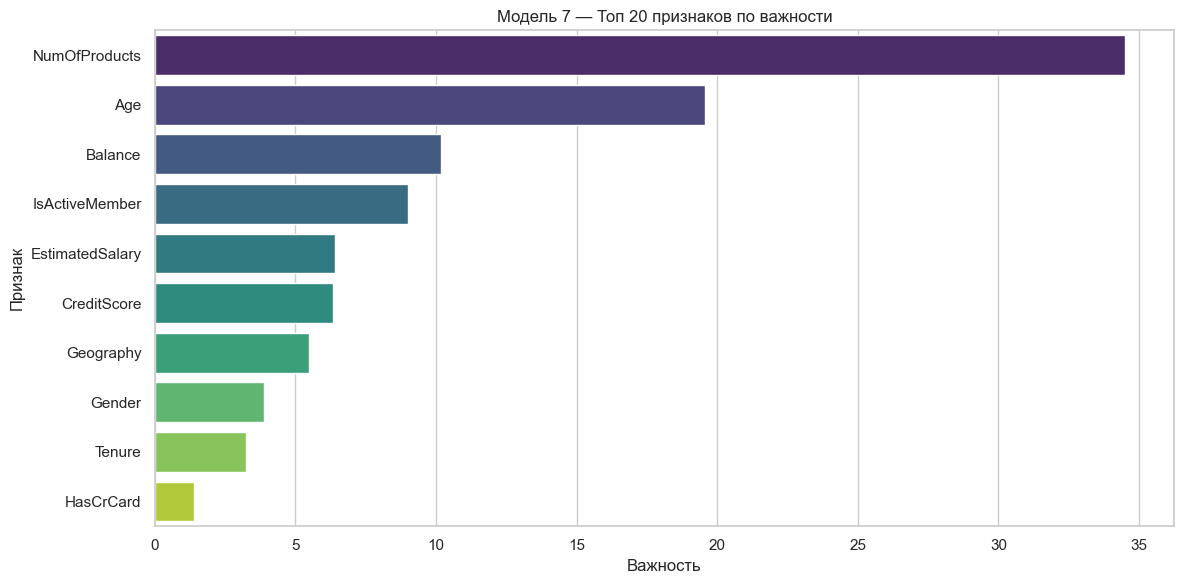

In [ ]:
feat_7 = plot_catboost_feature_importance(cb3, model_columns, name_model='Модель 7')

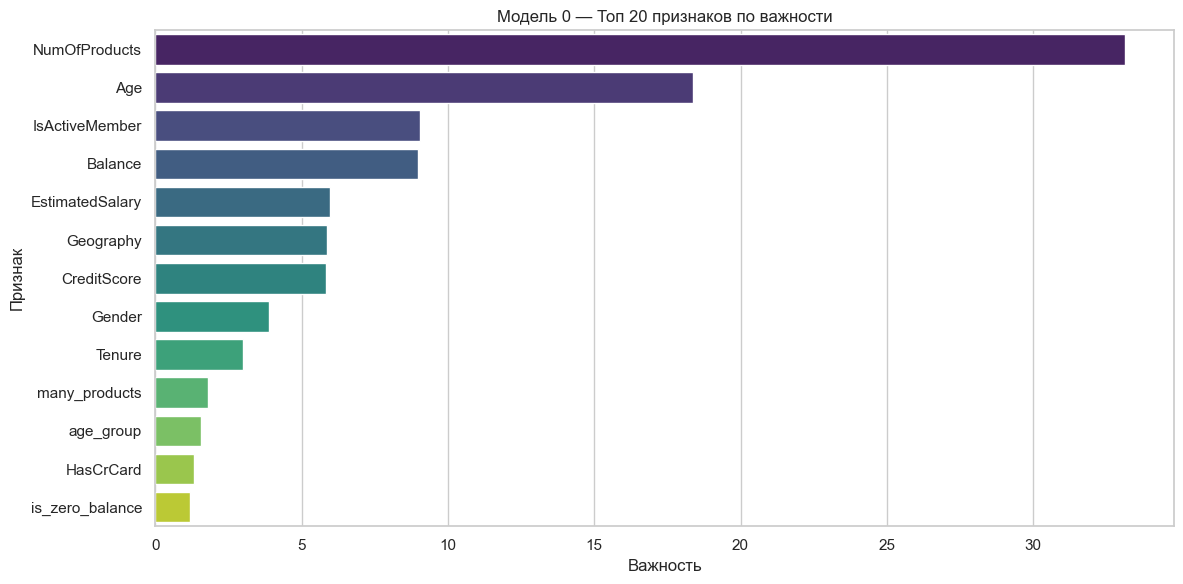

In [ ]:
feat_0 = plot_catboost_feature_importance(cb6, new_model_columns, name_model='Модель 0')

---

### 🔍 Общий анализ важности признаков двух моделей CatBoost:

| Признак           | Модель 7 Importance | Модель 0 Importance | Комментарий                                                 |
| ----------------- | ------------------- | ------------------- | ----------------------------------------------------------- |
| `NumOfProducts`   | **34.5**            | **33.2**            | Самый важный в обеих моделях.                               |
| `Age`             | 19.6                | 18.4                | Очень важен: чем старше клиент, тем выше вероятность ухода. |
| `Balance`         | 10.2                | 9.0                 | Также стабильно важен.                                      |
| `IsActiveMember`  | 9.0                 | 9.1                 | Один из ключевых факторов оттока.                           |
| `EstimatedSalary` | 6.4                 | 6.0                 | Умеренное влияние.                                          |
| `CreditScore`     | 6.3                 | 5.8                 | Стабильный, но не топовый.                                  |
| `Geography`       | 5.5                 | 5.9                 | Значим, особенно если в географию входят dummy-переменные.  |
| `Gender`          | 3.9                 | 3.9                 | Имеет некоторую предсказательную силу.                      |
| `Tenure`          | 3.2                 | 3.0                 | Невысокая, но стабильная важность.                          |
| `HasCrCard`       | 1.4                 | 1.3                 | Слабая важность.                                            |

---

### 📊 Новые признаки в модели 0:

| Новый признак     | Importance | Комментарий                                                           |
| ----------------- | ---------- | --------------------------------------------------------------------- |
| `many_products`   | 1.79       | Низкая важность. Видимо, `NumOfProducts` уже всё «объясняет».         |
| `age_group`       | 1.57       | Даёт дополнительную информацию, но незначительно — `Age` уже сильный. |
| `is_zero_balance` | 1.19       | Небольшой вклад. Вероятно, не все клиенты с нулевым балансом уходят.  |

---

### 📌 Выводы:

1. **Ядро важнейших признаков не изменилось**:

   * `NumOfProducts`, `Age`, `Balance`, `IsActiveMember` — основные драйверы оттока.

2. **Добавление новых признаков немного улучшило метрики**, но **вклад новых фичей по важности минимален**:

   * Их общая суммарная важность ≈ **4.5%**, то есть модель учла их, но они не критичны.

3. **Новые признаки не ухудшили модель**:

   * Актуально оставить их в финальной модели — как минимум, они не мешают.

---

### ✅ Рекомендации:

* **Оставить новые признаки**: хоть они и не стали ключевыми, они дают дополнительную информацию.
* **Возможно попробовать фичи взаимодействия**, например: `Age * Balance`, `IsActiveMember * NumOfProducts`.
* **Провести отбор признаков по importance или SHAP** — если нужно упростить модель или сделать её более интерпретируемой.

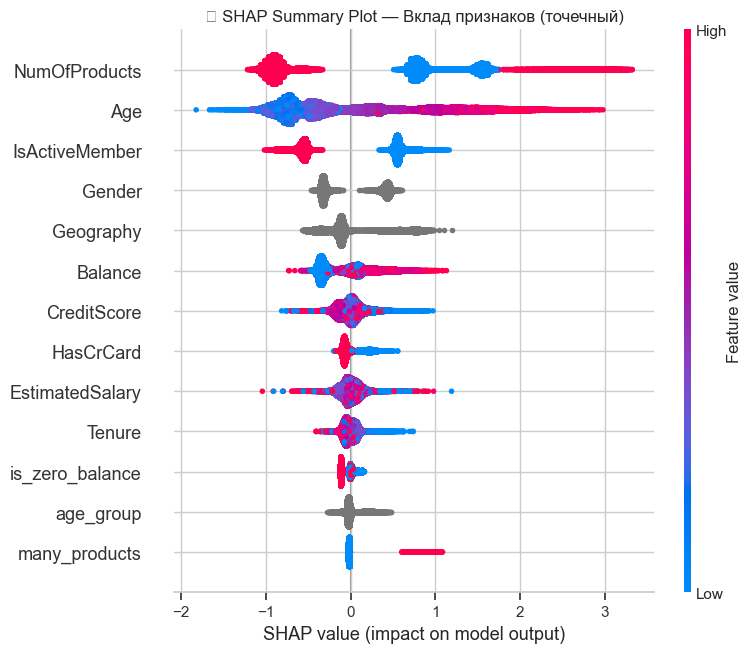

In [ ]:
# SHAP требует те признаки, на которых обучалась модель
X = train[new_model_columns]
y = train[target]

# SHAP explainer (CatBoost — поддерживается напрямую)
explainer = shap.TreeExplainer(cb6)
shap_values = explainer.shap_values(X)

# SHAP Summary Plot — вклад признаков при обучении

plt.figure(figsize=(14, 8))
plt.title("🎯 SHAP Summary Plot — Вклад признаков (точечный)")
shap.summary_plot(shap_values, X, plot_type="dot", show=True)

Этот график — **SHAP Summary Plot** показывает, **как каждый признак влияет на предсказания модели**

---

### 📌 Что показывает этот график?

* **Каждая точка** — это один объект из обучающей выборки.

* **Ось Y**: признаки, отсортированные по важности (чем выше — тем сильнее влияние).

* **Ось X**: значение SHAP → **вклад признака в предсказание** (влияет на увеличение/уменьшение вероятности ухода).

  * 👉 Правая сторона (SHAP > 0): признак увеличивает вероятность ухода (`Exited = 1`).
  * 👉 Левая сторона (SHAP < 0): признак уменьшает вероятность ухода (`Exited = 0`).

* **Цвет точки** — значение признака:

  * 🔴 Красный: высокое значение признака.
  * 🔵 Синий: низкое значение признака.
  * ⚫ Серый: категориальный или бинарный признак.

---

### 🔍 Как интерпретировать признаки?

1. **`NumOfProducts`** — 🔝 самый важный:

   * Низкие значения (синий) тянут SHAP вниз (уменьшают вероятность ухода).
   * Высокие (красный) сильно увеличивают вероятность ухода.
   * 🧠 Люди с 3–4 продуктами чаще уходят — возможно, это перегруженные клиенты.

2. **`Age`**:

   * Чем выше возраст (красный), тем выше SHAP — пожилые клиенты чаще уходят.
   * Молодые (синий) — остаются.

3. **`IsActiveMember`**:

   * Активные пользователи (1) имеют SHAP < 0 (остаются).
   * Неактивные (0) — чаще уходят. Всё логично.

4. **`Gender`, `Geography`**:

   * Влияние есть, но меньше.
   * Цвета нейтральны → просто категориальные признаки.

5. **`Balance`, `CreditScore`, `HasCrCard`**:

   * У них более умеренное влияние.
   * Пример: у `Balance` — большой разброс, но крайние значения не так сильно влияют.

6. **Инженерные признаки**:

   * `is_zero_balance`, `age_group`, `many_products` тоже дают вклад, хоть и не сильный.
   * Но видно, что `many_products` (красные точки справа) увеличивают вероятность ухода.

---

### 💡 Общие выводы:

* Наиболее значимы: **кол-во продуктов, возраст и активность**.
* Модель улавливает вполне логичные зависимости: активные, молодые клиенты с 1–2 продуктами — более лояльны.
* SHAP-подход позволяет понять не только важность признаков, но и **направление влияния**.
* Посмотрим `dependence plot` для топ-3 признаков, чтобы показать их влияние более детально.

Топ-3 признака по SHAP важности: ['NumOfProducts', 'Age', 'IsActiveMember']


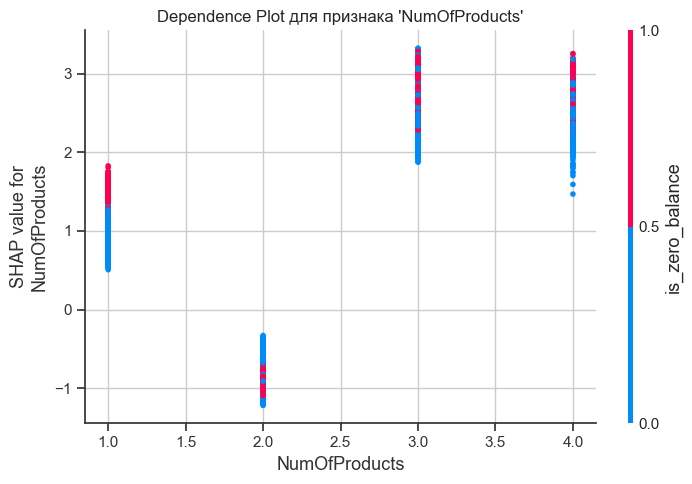

In [ ]:
def dependence_plot(feat, shap_values, X):
    shap.dependence_plot(feat, shap_values, X, show=False)
    plt.title(f"Dependence Plot для признака '{feat}'")
    plt.tight_layout()
    plt.show()


mean_abs_shap = np.abs(shap_values).mean(axis=0)
top3_idx = np.argsort(mean_abs_shap)[-3:][::-1]
top3_features = [X.columns[i] for i in top3_idx]

print("Топ-3 признака по SHAP важности:", top3_features)

dependence_plot(top3_features[0], shap_values, X)

# <font color='#11a642' size='5'>  🧠 SHAP Summary Plot и согласование с Dependence Plot

На первый взгляд кажется, что выводы из двух графиков противоречат друг другу, но при более детальном анализе можно обнаружить их взаимодополняющий характер.

## 📌 Ключевые расхождения и их объяснение:

1. **По NumOfProducts**:
   - *Dependence Plot*: Показывает, что 1 продукт → высокий риск ухода, 3-4 продукта → низкий риск
   - *Summary Plot*: Утверждает обратное - "Люди с 3–4 продуктами чаще уходят"

   **Объяснение**: В Summary Plot цвета показывают абсолютные значения признака (красный = больше продуктов), а в Dependence Plot - конкретные значения (1, 2, 3, 4). В данных есть:
   - Основная масса клиентов с 1-2 продуктами (синие точки слева)
   - Небольшая группа с аномально большим количеством продуктов (4), которые действительно уходят (красные точки справа)

2. **По Age**:
   Оба графика согласуются - пожилые клиенты (красные точки справа в Summary) более склонны к уходу.

3. **По IsActiveMember**:
   Полное согласование - неактивные клиенты чаще уходят.

## 🔍 Интерпретация NumOfProducts:

1. **Основной тренд (Dependence Plot)**:
   - 1 продукт → высокий риск
   - 2 продукта → нейтрально
   - 3-4 продукта → низкий риск

2. **Аномальные случаи (Summary Plot)**:
   - Клиенты с экстремально большим количеством продуктов (3+), которые:
     - Либо перегружены сервисами
     - Либо используют продукты не по назначению
     - Либо это ошибки в данных
   - Составляют малую долю, но сильно влияют на общую картину в Summary Plot

## 💡 Общие выводы:

1. Для большинства клиентов (1-4 продукта) работает закономерность:
   - Минимальное (1) и максимальное (4) количество продуктов → риск ухода
   - Оптимум - 2-3 продукта

2. Существует небольшая группа "аномальных" клиентов с 4 продуктами, которые:
   - Сильно влияют на Summary Plot
   - Требуют отдельного исследования
   - Возможно, их следует исключить или обработать как outliers

3. Оба графика по-своему правы:
   - Dependence Plot показывает основной тренд
   - Summary Plot выявляет аномалии и общие закономерности

Такой комплексный анализ позволяет получить более полное и точное представление о поведении клиентов.

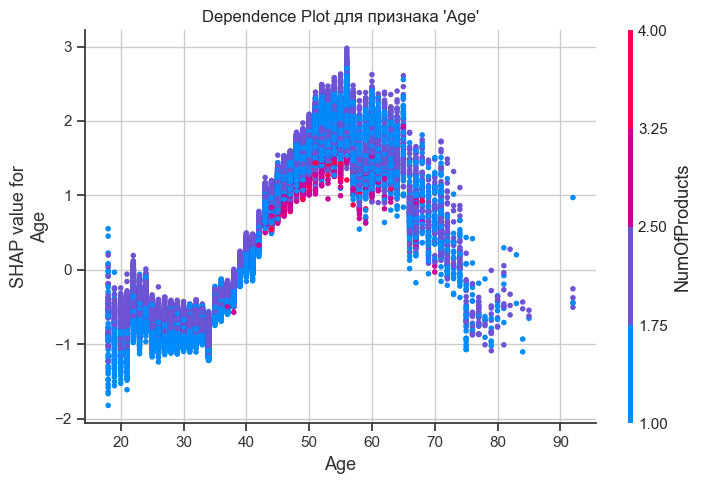

In [ ]:
dependence_plot(top3_features[1], shap_values, X)

# 🧠 Интерпретация Dependence Plot для признака 'Age'

Этот график показывает взаимодействие между возрастом клиента (ось X) и количеством продуктов (цвет точек), а также их совместное влияние на вероятность ухода клиента (SHAP values по оси Y).

## 🔍 Ключевые наблюдения:

1. **Основная зависимость от возраста**:
   - Чем старше клиент, тем выше SHAP-значение → выше вероятность ухода
   - Резкий рост риска начинается после 40 лет
   - Пиковый риск у клиентов 60-70 лет
   - После 70 лет наблюдается небольшое снижение риска

2. **Взаимодействие с NumOfProducts**:
   - Красные точки (4 продукта) преимущественно в отрицательной зоне SHAP → клиенты с максимальным количеством продуктов менее склонны уходить независимо от возраста
   - Фиолетовые/синие точки (1-2 продукта) показывают сильную положительную корреляцию с возрастом → для клиентов с малым количеством продуктов возраст является критическим фактором риска

3. **Интересные закономерности**:
   - Молодые клиенты (20-30 лет) демонстрируют низкий риск ухода независимо от количества продуктов
   - Клиенты среднего возраста (30-50 лет) с 3-4 продуктами (желто-зеленые точки) имеют нейтральный риск
   - Пожилые клиенты (50+) с 1-2 продуктами (синие точки) - группа максимального риска

## 💡 Бизнес-инсайты:

1. **Для разных возрастных групп**:
   - **Молодые клиенты (20-30)**: Низкий риск ухода, можно фокусироваться на кросс-продажах
   - **Средний возраст (30-50)**: Ключевой фактор - количество продуктов (3-4 продукта делают их стабильными)
   - **Клиенты 50+**: Требуют особого внимания, особенно если у них 1-2 продукта

2. **Рекомендации по удержанию**:
   - Для клиентов 50+ с 1-2 продуктами разработать специальные программы лояльности
   - Клиентам 40-60 лет предлагать дополнительные продукты (3-4 продукта значительно снижают риск ухода)
   - Молодым клиентам предлагать премиальные продукты, так как они демонстрируют высокую лояльность

3. **Продуктовая стратегия**:
   - Оптимальное количество продуктов для снижения риска ухода:
     - 30-50 лет: 3 продукта
     - 50+: 4 продукта
   - Особенно важно увеличивать продуктовую корзину для клиентов после 40 лет

График подтверждает, что возраст и количество продуктов имеют синергетический эффект на лояльность клиентов, и эти факторы нужно рассматривать совместно при разработке стратегий удержания.

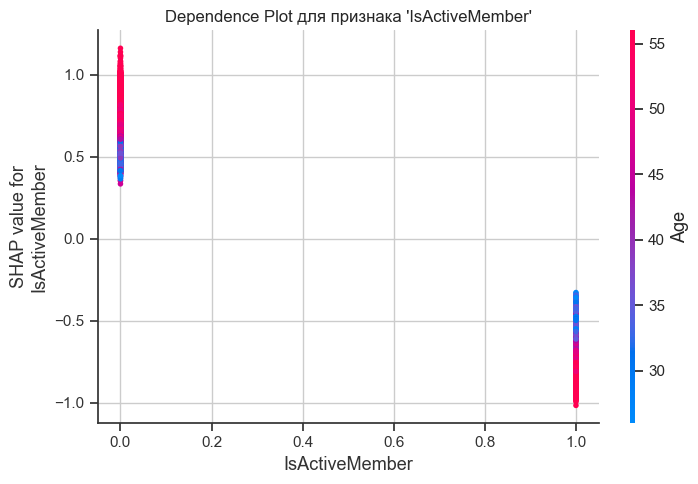

In [ ]:
dependence_plot(top3_features[2], shap_values, X)

# 🧠 Интерпретация Dependence Plot для признака 'IsActiveMember'

Этот график показывает, как активность клиента (IsActiveMember) взаимодействует с его возрастом (цвет точек) и влияет на вероятность ухода (SHAP values).

## 🔍 Основные выводы:

1. **Сильное влияние активности**:
   - Активные клиенты (IsActiveMember=1) имеют отрицательные SHAP-значения (снижают вероятность ухода)
   - Неактивные клиенты (IsActiveMember=0) имеют значения около нуля (нейтральное влияние)

2. **Возрастная зависимость**:
   - Для активных клиентов (нижняя группа точек):
     - Чем старше клиент (красные/оранжевые точки), тем сильнее отрицательное влияние активности (SHAP ~ -1.0)
     - Молодые активные клиенты (синие точки) тоже имеют отрицательный SHAP, но менее выраженный (~ -0.5)
   - Для неактивных клиентов (верхняя группа точек) возраст практически не влияет на SHAP-значения

3. **Ключевые инсайты**:
   - Активность особенно важна для удержания клиентов 40+ лет
   - Молодые клиенты менее чувствительны к активности - остаются даже при низкой активности
   - Неактивность одинаково опасна для всех возрастных групп

## 💡 Бизнес-рекомендации:

1. **Для разных возрастных групп**:
   - **Клиенты 40+**: Крайне важно поддерживать их активность (специальные программы для этой возрастной группы)
   - **Молодые клиенты**: Можно меньше ресурсов тратить на их активацию, так как они и так остаются

2. **Программы удержания**:
   - Разработать возраст-специфичные программы активации:
     - Для 40-55 лет: персонализированные предложения, повышенное внимание
     - Для 30-40 лет: автоматизированные напоминания, бонусы за активность
   - Для неактивных клиентов всех возрастов: программы реактивации

3. **Мониторинг**:
   - Особо отслеживать активность клиентов старше 40 лет - их уход наиболее вероятен при снижении активности
   - Ввести систему "раннего предупреждения" по снижению активности

График подтверждает, что активность клиента - важный фактор удержания, но его влияние сильно зависит от возраста клиента, что необходимо учитывать в CRM-стратегиях.

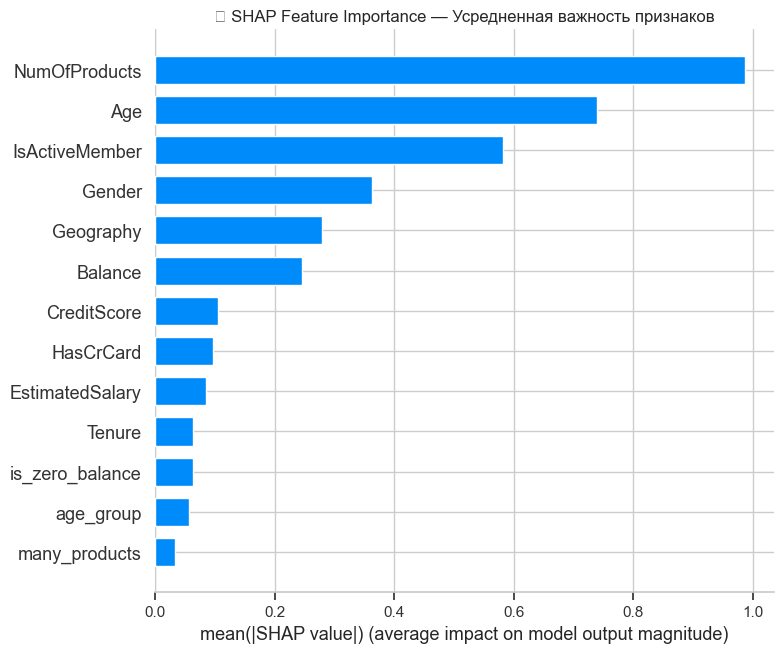

In [ ]:
# SHAP bar plot — усреднённая важность признаков

plt.figure(figsize=(16, 8))
plt.title("📊 SHAP Feature Importance — Усредненная важность признаков")
shap.summary_plot(shap_values, X, plot_type="bar", show=True)

# 🧠 Интерпретация SHAP Feature Importance Plot

Этот график представляет собой ранжированный список признаков по их важности для модели, измеренной через среднюю абсолютную величину SHAP-значений.

## 📌 Ключевые наблюдения:

1. **Топ-3 наиболее важных признака**:
   - **NumOfProducts** (абсолютный лидер по важности)
   - **Age** (второй по значимости)
   - **IsActiveMember** (третий важнейший фактор)

2. **Средняя группа влияния**:
   - **Geography** и **Gender** - заметное, но умеренное влияние
   - **Balance** и **CreditScore** - финансовые показатели средней важности

3. **Наименее значимые факторы**:
   - **HasCrCard**, **EstimatedSalary**, **Tenure**
   - Инженерные признаки (**is_zero_balance**, **age_group**, **many_products**) вносят минимальный вклад

## 🔍 Глубинная интерпретация:

1. **Продуктовая стратегия**:
   - Количество продуктов - ключевой драйвер удержания клиентов
   - Подтверждает выводы из предыдущих графиков о критической важности этого параметра

2. **Демографические факторы**:
   - Возраст и активность клиента - фундаментальные показатели лояльности
   - География и пол имеют существенное, но меньшее влияние

3. **Финансовые показатели**:
   - Удивительно низкая важность кредитного скоринга и зарплаты
   - Баланс счета важнее, чем наличие кредитной карты

## 💡 Бизнес-выводы:

1. **Приоритеты в управлении клиентским опытом**:
   - Фокус на увеличение количества продуктов у клиентов
   - Специальные программы для разных возрастных групп
   - Система мотивации клиентской активности

2. **Оптимизация данных**:
   - Можно упростить модель, исключив наименее значимые признаки
   - Сфокусировать сбор данных на наиболее важных параметрах

3. **Маркетинговая стратегия**:
   - Сегментирование клиентов прежде всего по количеству продуктов и возрасту
   - Разные подходы для активных/неактивных клиентов

График подтверждает, что модель в первую очередь обращает внимание на "поведенческие" характеристики клиентов (количество продуктов, активность), а не на их финансовые параметры, что соответствует современным тенденциям в customer retention.

# <font color='#11a642' size='6'> **permitation feature importance**

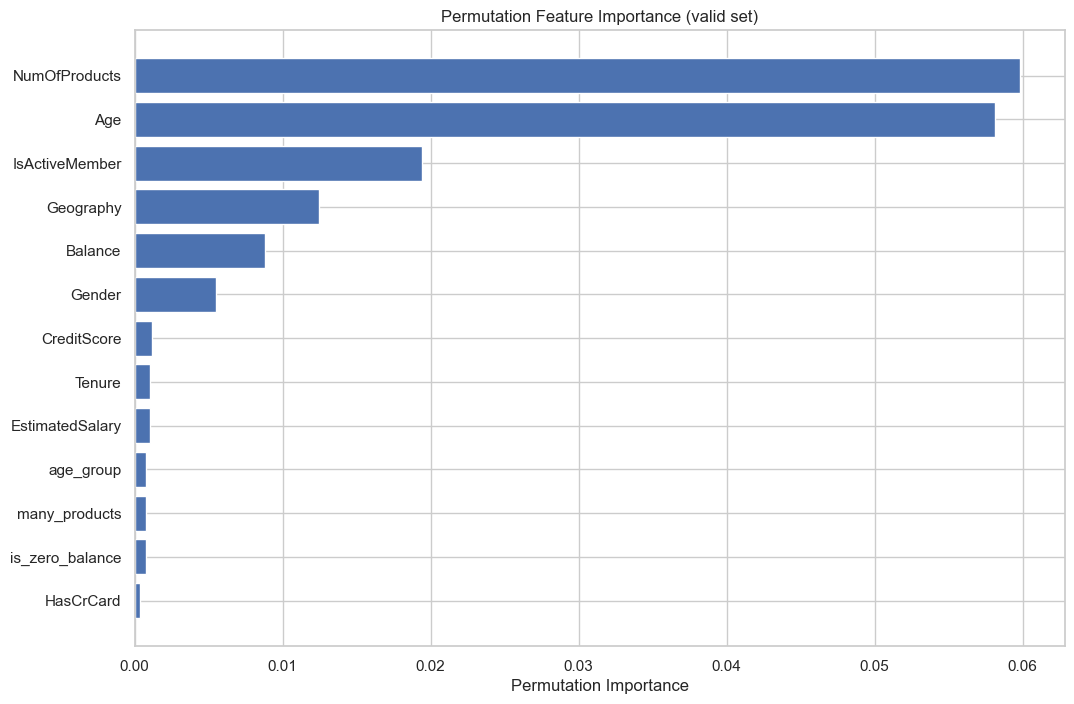

In [ ]:
X_valid, y_valid = valid[new_model_columns], valid[target]

# Вычисление важности признаков
perm_importance = permutation_importance(
    cb6,      # наша CatBoost модель
    X_valid,  # валидационные данные
    y_valid,  # валидационные метки
    n_repeats=10,
    random_state=SEED,
)

# Сортировка признаков по важности
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
features = X_valid.columns[sorted_idx]

# Построение графика
plt.figure(figsize=(12, 8))
plt.barh(features, perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance (valid set)")
plt.gca().invert_yaxis()  # чтобы самый важный признак был сверху
plt.show()

# 🧠 Сравнение Permutation Importance и SHAP Importance

На основе предоставленного графика Permutation Importance и ранее обсуждавшихся SHAP-результатов можно провести детальное сравнение:

## 📌1. Согласующиеся моменты:

**Топ-3 признака полностью совпадают** в обоих методах:
- **NumOfProducts** (абсолютный лидер)
- **Age**
- **IsActiveMember**

Это сильный сигнал, что эти признаки действительно наиболее значимы для модели.

## 🔍 2. Расхождения и их интерпретация:

**География (Geography)**:
- В SHAP была в середине списка
- В Permutation Importance поднялась на 4 место (после топ-3)
- **Вывод**: Возможно, географическая принадлежность важна для обобщающей способности модели больше, чем показывал SHAP

**Финансовые показатели (Balance, CreditScore)**:
- В SHAP Balance был важнее CreditScore
- В Permutation Importance они почти равны
- **Вывод**: Оба признака умеренно важны для точности модели

**Пол (Gender)**:
- В SHAP был выше финансовых показателей
- В Permutation опустился ниже Balance и CreditScore
- **Вывод**: Пол влияет на отдельные предсказания (SHAP), но меньше влияет на общую точность

## ⚠️ 3. Наименее важные признаки:

Оба метода согласны, что эти признаки малозначимы:
- HasCrCard
- is_zero_balance
- many_products
- age_group
- EstimatedSalary

## 👉 4. Особые случаи:

**Tenure** (время сотрудничества с банком):
- В SHAP был среди аутсайдеров
- В Permutation Importance немного выше
- **Возможная причина**: Может иметь нелинейные взаимосвязи, которые SHAP не улавливает

## 💡 Выводы и рекомендации:

1. **Для feature engineering**:
   - Можно попробовать удалить HasCrCard, is_zero_balance и другие низкозначимые признаки
   - Сфокусироваться на топ-5: NumOfProducts, Age, IsActiveMember, Geography, Balance

2. **Для интерпретации модели**:
   - Основные драйверы (NumOfProducts, Age, IsActiveMember) подтверждены двумя методами
   - Geography заслуживает большего внимания, чем казалось по SHAP

3. **Для бизнес-решений**:
   - Приоритеты остаются прежними: продукты, возраст и активность клиентов
   - Географический фактор следует учитывать в региональных стратегиях

### 🎯 График Permutation Importance подтвердил основные выводы SHAP-анализа, но добавил важные нюансы по второстепенным признакам.

# ⚖️  <font color='#11a642' size='6'> Сравнение с результатами из ДЗ 9
    
- В ДЗ-9 у меня сравнивались только модели LogisticRegression и там победила модель с подбором гиперпараметров и обработка данных с удалением выбросов.
- В этой работе были добавлены модели SGDClassifier и CatBoostClassifier.
- Для CatBoostClassifier удаление выбросов ухудшило метрики.
- CatBoostClassifier "из коробки" показал отличные результаты.
- Подбор гиперпараметров выполнялся с помошью Optuna и принес небольшие улучшения метрик.    
- Победила модель CatBoostClassifier с подбором гиперпараметров и новыми признаками.
- Новые признаки сделали модель чуть более стабильной и незначительно улучшили метрики.